# Nombre: Jesús Alberto Aréchiga Carrillo

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim

Imagen gray: (471, 558), dtype: uint8
Ground truth: (471, 558), dtype: uint8


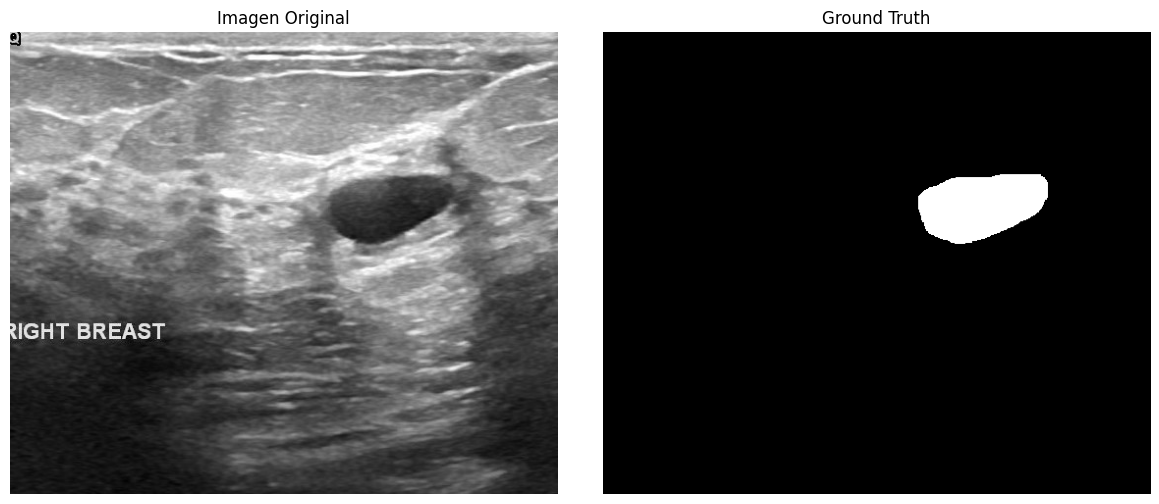

In [ ]:
img = cv2.imread("benign.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gt_img = cv2.imread("benign (3)_mask.png")
ground_truth = cv2.cvtColor(gt_img, cv2.COLOR_BGR2GRAY)
_, ground_truth = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)

print(f"Imagen gray: {gray.shape}, dtype: {gray.dtype}")
print(f"Ground truth: {ground_truth.shape}, dtype: {ground_truth.dtype}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')
axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title('Ground Truth')
axes[1].axis('off')
plt.tight_layout()
plt.show()

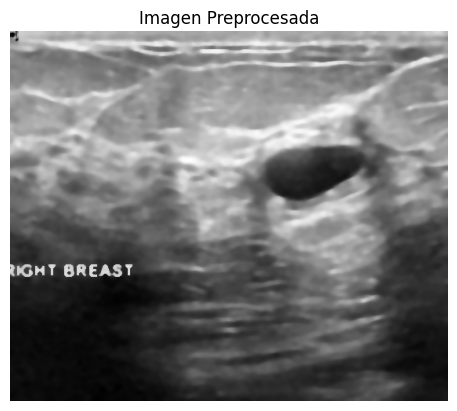

In [ ]:
bilateral = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
median = cv2.medianBlur(bilateral, 5)

plt.imshow(median, cmap='gray')
plt.title('Imagen Preprocesada')
plt.axis('off')
plt.show()

In [ ]:
def region_growing(img, seed, threshold):
    """
    Algoritmo de crecimiento de región.

    Args:
        img: Imagen en escala de grises
        seed: Tupla (x, y) con la semilla inicial
        threshold: Umbral de diferencia de intensidad para incluir vecinos

    Returns:
        Máscara binaria de la región segmentada
    """
    h, w = img.shape
    segmented = np.zeros((h, w), dtype=np.uint8)
    visited = np.zeros((h, w), dtype=bool)

    # Valor de intensidad de la semilla
    seed_value = float(img[seed[1], seed[0]])

    # Cola de píxeles a procesar
    queue = [seed]
    visited[seed[1], seed[0]] = True

    # Vecindad de 8 conexiones
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 (0, -1),          (0, 1),
                 (1, -1),  (1, 0), (1, 1)]

    while queue:
        x, y = queue.pop(0)

        # Verificar si el píxel cumple el criterio
        if abs(float(img[y, x]) - seed_value) <= threshold:
            segmented[y, x] = 255

            # Agregar vecinos no visitados
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy

                if 0 <= nx < w and 0 <= ny < h and not visited[ny, nx]:
                    visited[ny, nx] = True
                    queue.append((nx, ny))

    return segmented

Semilla: (384, 176)


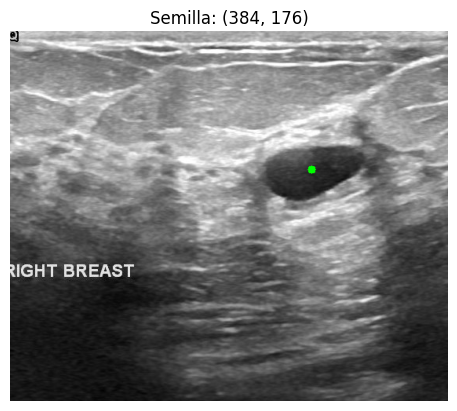

In [ ]:
# Encontrar semilla usando el ground truth
seed = find_seed_point(median, ground_truth)
print(f'Semilla: {seed}')

img_seed = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
cv2.circle(img_seed, seed, 5, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(img_seed, cv2.COLOR_BGR2RGB))
plt.title(f'Semilla: {seed}')
plt.axis('off')
plt.show()

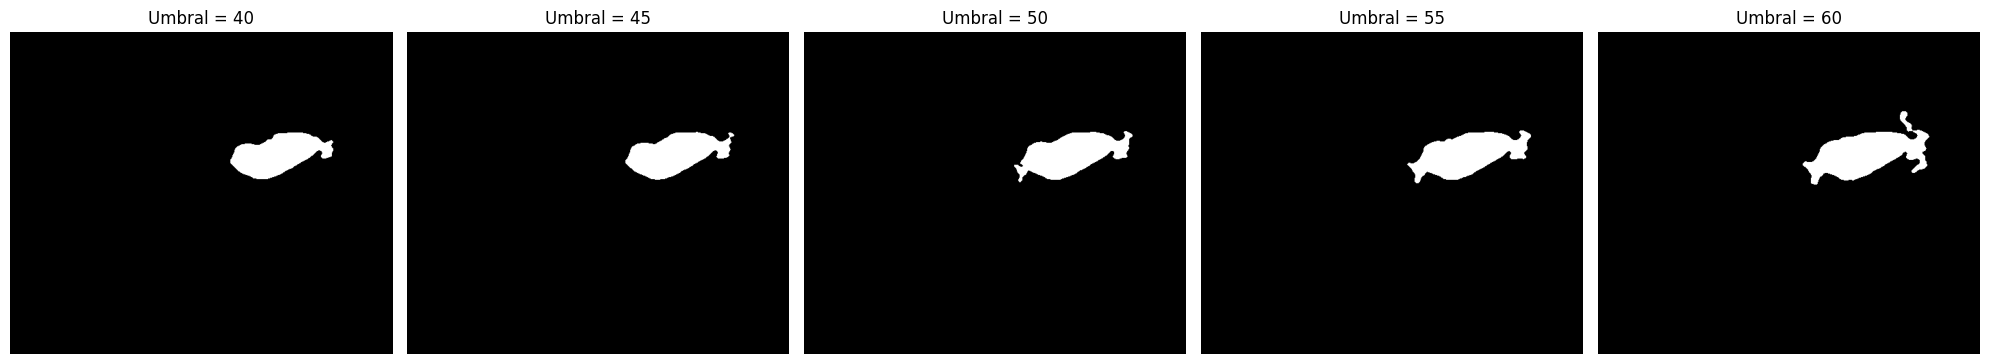

In [ ]:
thresholds = [40, 45, 50, 55, 60]

fig, axes = plt.subplots(1, len(thresholds), figsize=(20, 4))

results = {}
for i, thresh in enumerate(thresholds):
    segmented = region_growing(median, seed, thresh)
    results[thresh] = segmented

    axes[i].imshow(segmented, cmap='gray')
    axes[i].set_title(f'Umbral = {thresh}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_mse(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2) ** 2)
    return mse

def calculate_ssim(img1, img2):
    score, _ = ssim(img1, img2, full=True)
    return score

def calculate_accuracy(pred, gt):
    pred_binary = (pred > 127).astype(np.uint8)
    gt_binary = (gt > 127).astype(np.uint8)

    correct = np.sum(pred_binary == gt_binary)
    total = pred_binary.size
    accuracy = correct / total
    return accuracy

def calculate_dice(pred, gt):
    pred_binary = pred > 127
    gt_binary = gt > 127

    intersection = np.logical_and(pred_binary, gt_binary).sum()
    dice = (2 * intersection) / (pred_binary.sum() + gt_binary.sum())
    return dice

def calculate_iou(pred, gt):
    pred_binary = pred > 127
    gt_binary = gt > 127

    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    iou = intersection / union if union > 0 else 0
    return iou

In [ ]:
best_dice = 0
best_thresh = 0
best_mask = None

for thresh, segmented in results.items():
    mse = calculate_mse(segmented, ground_truth)
    ssim_score = calculate_ssim(segmented, ground_truth)
    acc = calculate_accuracy(segmented, ground_truth)
    dice = calculate_dice(segmented, ground_truth)


    if dice > best_dice:
        best_dice = dice
        best_thresh = thresh
        best_mask = segmented

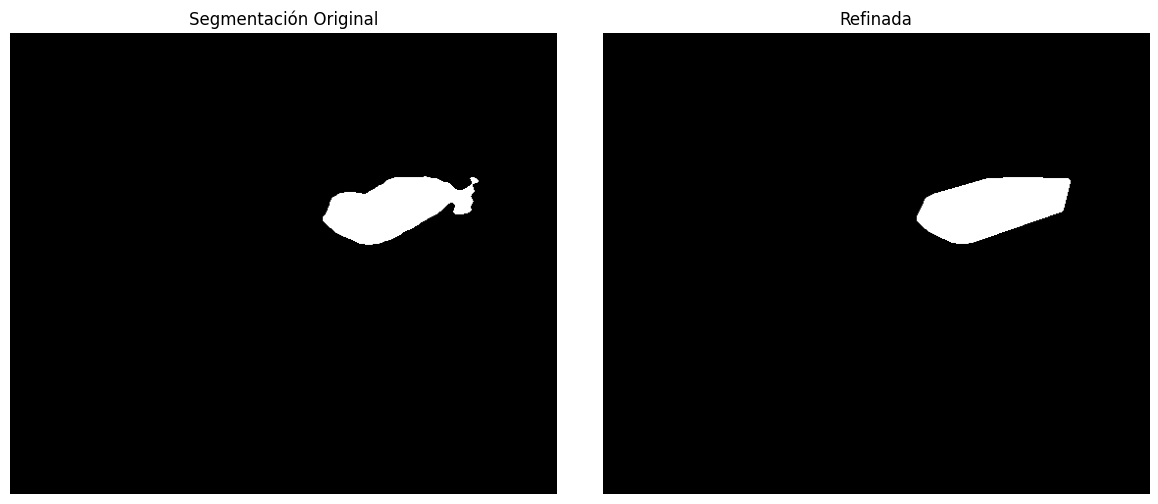

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

# Cierre
refined = cv2.morphologyEx(best_mask, cv2.MORPH_CLOSE, kernel_large, iterations=3)

# Convex Hull
contours_ref, _ = cv2.findContours(refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours_ref:
    largest_contour = max(contours_ref, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour)
    refined = np.zeros_like(gray)
    cv2.drawContours(refined, [hull], -1, 255, -1)

# Erosión leve
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
refined = cv2.erode(refined, kernel_erode, iterations=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(best_mask, cmap='gray')
axes[0].set_title('Segmentación Original')
axes[0].axis('off')
axes[1].imshow(refined, cmap='gray')
axes[1].set_title('Refinada')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Conclusiones
La segmentación por crecimiento de región es una técnica para identificar áreas de interés basadas en la similitud de intensidad a partir de un punto de semilla. Su principal fortaleza reside en su simplicidad y en la capacidad de generar regiones conectadas. Su rendimiento es sensible a la elección del punto de semilla y del umbral.  Las operaciones de refinamiento posteriores, como el cierre morfológico y el convex hull, fueron necesarias para suavizar los contornos y corregir imperfecciones en la máscara generada inicialmente por el crecimiento de región, mejorando la forma final del objeto segmentado.

